In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import datetime as dt

from dateutil.relativedelta import *
from dateutil.parser import *
from sqlalchemy.dialects.sqlite import \
            BLOB, BOOLEAN, CHAR, DATE, DATETIME, DECIMAL, FLOAT, \
            INTEGER, NUMERIC, JSON, SMALLINT, TEXT, TIME, TIMESTAMP, \
            VARCHAR

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.sql import select
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, cast, desc
import sqlite3

# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite",echo=False)

# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare (engine, reflect = True)

# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [3]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [4]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()
measurements_df = pd.read_sql_query('SELECT * from measurement',con=conn)
stations_df = pd.read_sql_query('SELECT * from station',con=conn)

In [5]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.
latest_date = session.query(measurement.date).order_by((measurement.date.desc())).first()
end_date=dt.datetime.strptime(latest_date[0],'%Y-%m-%d')
timestamp_end = dt.datetime.strftime(end_date,'%Y-%m-%d')

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
start_date = end_date + relativedelta(months=-12)
timestamp_start = dt.datetime.strftime(start_date,'%Y-%m-%d')

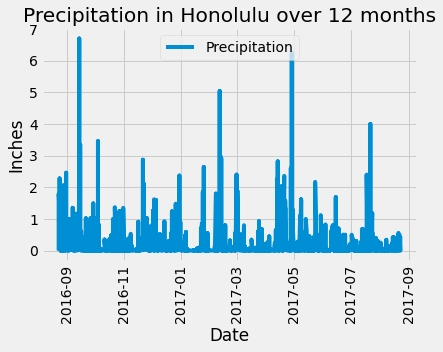

In [10]:
# Perform a query to retrieve the data and precipitation scores
prcp_result = engine.execute('SELECT date,prcp FROM measurement WHERE date BETWEEN :start AND :end',(timestamp_start,timestamp_end)).fetchall()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_result)
prcp_df[0]=pd.to_datetime(prcp_df[0])
prcp_final = prcp_df.rename(columns={0:'Date',1:'Precipitation'}).set_index('Date').dropna()

# Sort the dataframe by date
prcp_chart = prcp_final.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(prcp_chart.index, prcp_chart["Precipitation"],label="Precipitation")
plt.legend(loc="upper center")
plt.title("Precipitation in Honolulu over 12 months")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_chart.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(func.count(distinct(station.station))).all()
num_stations

[(9)]

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
prcp_activity = session.query(measurement.station,(func.count(measurement.prcp))).\
    group_by(measurement.station).\
    order_by(desc(measurement.station)).all()
prcp_activity

[('USC00519523', 2572),
 ('USC00519397', 2685),
 ('USC00519281', 2772),
 ('USC00518838', 342),
 ('USC00517948', 683),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00513117', 2696),
 ('USC00511918', 1932)]

In [14]:
active_station_id = session.query(measurement.station).\
    group_by(measurement.station).\
    order_by(desc(measurement.station)).first()
active_station_id[0]

'USC00519523'

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_stats = session.query(measurement.tobs).\
    filter_by(station = active_station_id[0]).all()
max_temp = session.query(func.max(measurement.tobs)).\
    filter_by(station = active_station_id[0]).all()
max_temp

[(85.0)]

In [16]:
min_temp = session.query(func.min(measurement.tobs)).\
    filter_by(station = active_station_id[0]).all()
min_temp

[(56.0)]

In [17]:
avg_temp = session.query(func.avg(measurement.tobs)).\
    filter_by(station = active_station_id[0]).all()
avg_temp

[(74.5436493068565)]

In [18]:
annual_activestn_tobs = engine.execute('SELECT date,tobs FROM measurement WHERE date BETWEEN :start AND :end AND station == :station_id',(timestamp_start,timestamp_end,active_station_id[0])).fetchall()
# annual_activestn_tobs

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
annual_activestn_tobs = engine.execute('SELECT date,tobs FROM measurement WHERE date BETWEEN :start AND :end AND station == :station_id',(timestamp_start,timestamp_end,active_station_id[0])).fetchall()
# annual_activestn_tobs

tobs_df = pd.DataFrame(annual_activestn_tobs)
tobs_df[0]=pd.to_datetime(tobs_df[0])
tobs_final = tobs_df.rename(columns={0:'Date',1:'Temperature'}).set_index('Date').dropna()
tobs_chart = tobs_final.sort_values(by=['Date'])

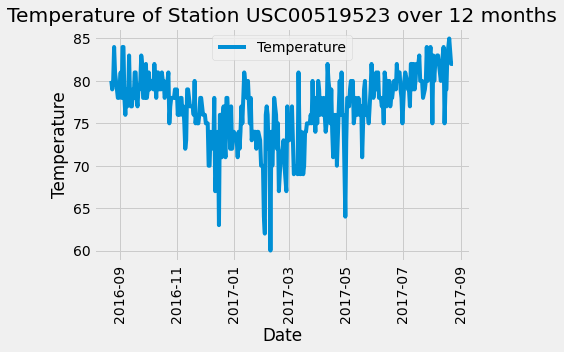

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data
figsize=(13,13)
plt.plot(tobs_chart.index, tobs_chart['Temperature'],label="Temperature")
plt.legend(loc="upper center")
plt.title("Temperature of Station "+ str(active_station_id[0]) + " over 12 months")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.xticks(rotation=90)
plt.show()

# Close session

In [23]:
# Close Session
session.close()